In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# plots show in the notebook
%matplotlib inline

# additional configuration (optional)
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

In [2]:
ds_esm4_static = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/ESM4/piControl/ocean_monthly.static.nc')
ds_esm4_perturbation = xr.open_dataset('/home/rlb/esm4_somip_prcme_adj_perturbation.nc')

ds_esm4_perturbation

<xarray.Dataset>
Dimensions:    (latitude: 576, longitude: 720, time: 12)
Coordinates:
  * time       (time) object 0001-01-16 00:00:00 ... 0001-12-16 00:00:00
  * latitude   (latitude) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
  * longitude  (longitude) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
Data variables:
    prcme_adj  (time, latitude, longitude) float64 ...
Attributes:
    history:  Thu Oct  8 12:24:45 2020: ncatted -a units,prcme_adj,c,c,kg m-2...
    NCO:      netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net, C...

In [1]:
#Determine how many points in the xh direction and yh direction are 1 degree
#import numpy as np
#np.set_printoptions(threshold=np.inf, linewidth=200)
#ds_esm4_static.xh.values

In [6]:
wet_mask = ds_esm4_static.wet

land = wet_mask.where(wet_mask==0)
ocean = wet_mask.where(wet_mask==1)
ocean_zero = ocean*0

land_ones = ocean_zero.where(ocean_zero==0,1)
land = land_ones.where(land_ones==1)

#select only region south of 60S to perform ffill on
forward_fill_land_y = land.sel(yh=slice(-80,-62.5)).ffill(dim='yh',limit=6)
forward_fill_land_x = land.sel(yh=slice(-80,-62.5)).ffill(dim='xh',limit=3)
backward_fill_land_x = land.sel(yh=slice(-80,-62.5)).bfill(dim='xh',limit=3)

fill_wet_y = forward_fill_land_y*wet_mask
fill_wet_x = forward_fill_land_x*wet_mask
bfill_wet_x = backward_fill_land_x*wet_mask

coast_mask_y = fill_wet_y.fillna(0)
coast_mask_x = fill_wet_x.fillna(0)
coast_mask_bfillx = bfill_wet_x.fillna(0)

total = coast_mask_y + coast_mask_x 
zeros = total.where(total==0)
mask_of_zeros = zeros.fillna(1)

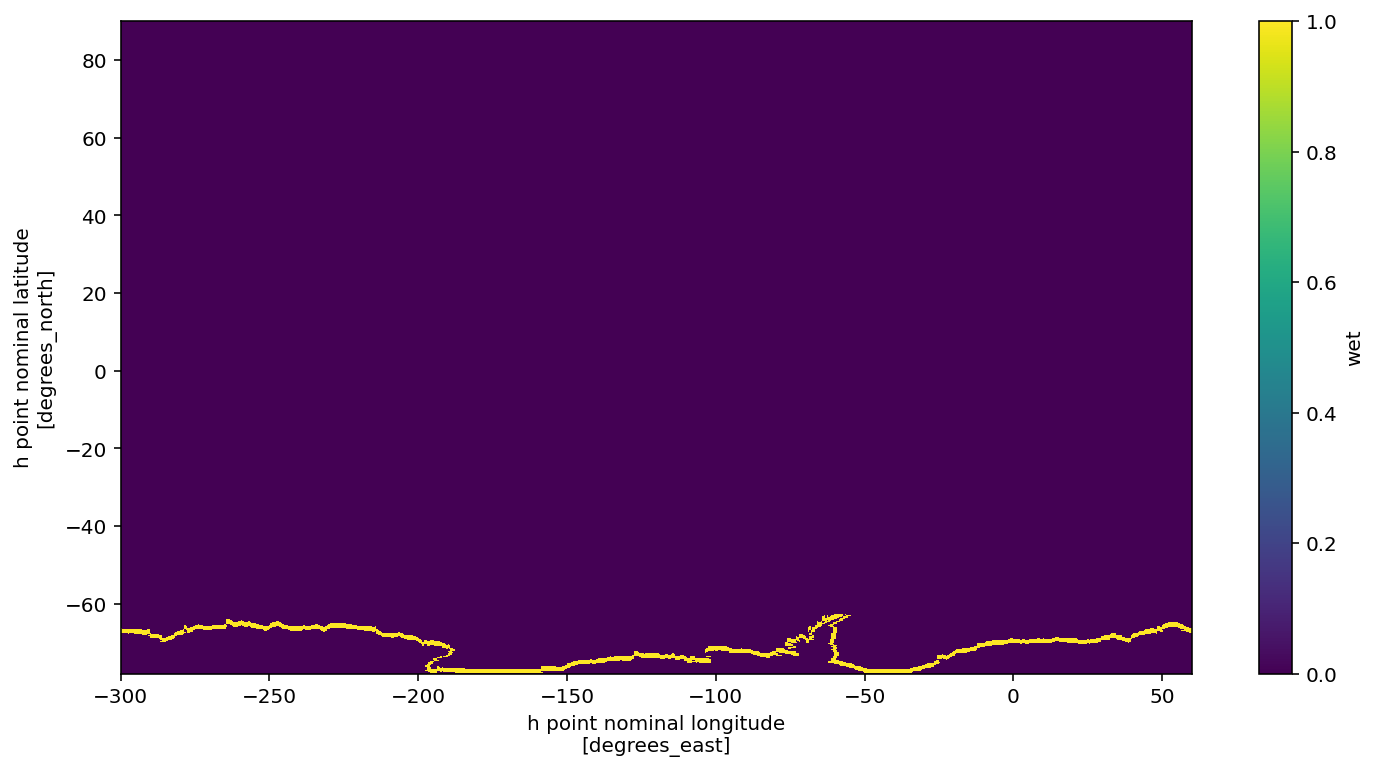

In [7]:
#mask_of_zeros has dimensions yh=176, we need this to be back to the original yh dimensions of 1080
mask = mask_of_zeros.broadcast_like(ocean_zero)
mask_fill_nan = mask.fillna(0)
mask_fill_nan.plot()

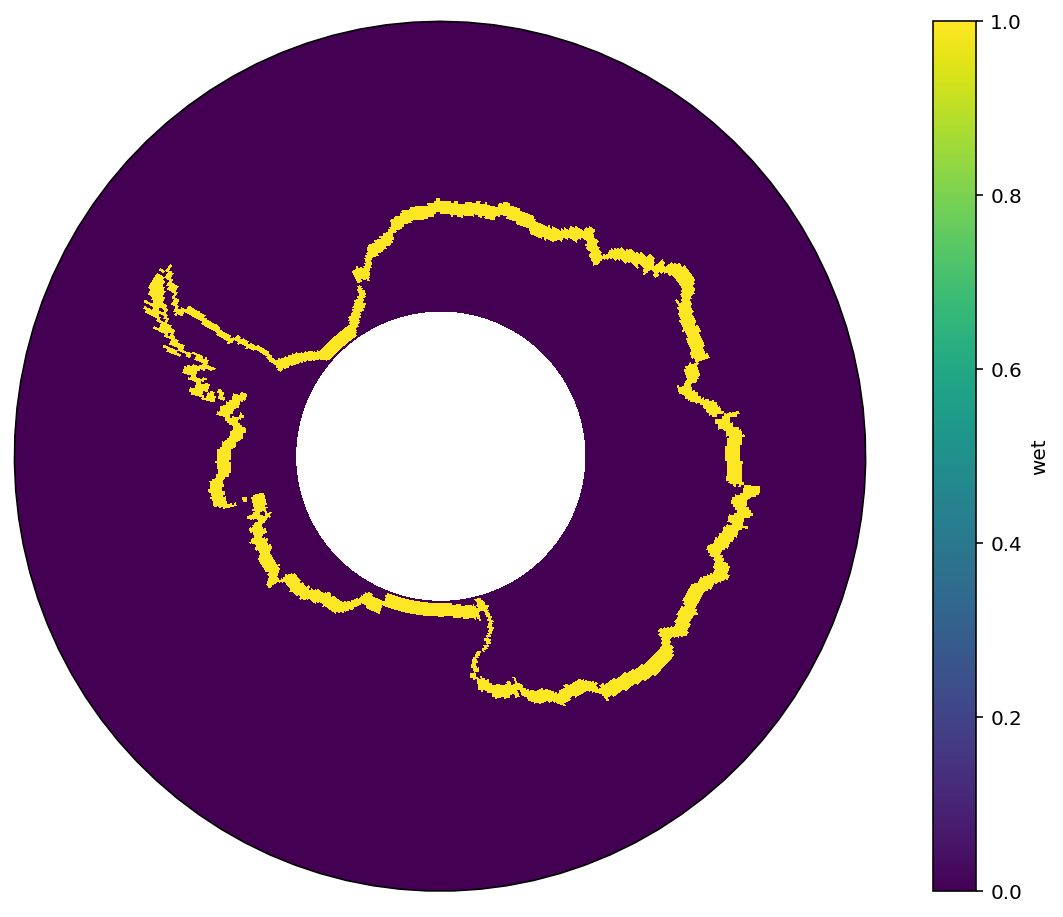

In [8]:
import cartopy.crs as ccrs
import numpy as np
import matplotlib.path as mpath

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

subplot_kws=dict(facecolor='grey')

plt.figure(figsize=[12,8])

projection=ccrs.SouthPolarStereo()
ax = plt.axes(projection=projection)
ax.set_extent([-180,180,-90,-55], ccrs.PlateCarree())
ax.set_boundary(circle,transform=ax.transAxes)

p = mask_fill_nan.plot(x='xh', y='yh',
                        transform=ccrs.PlateCarree())


In [11]:
# Scale to a total of 0.1025 Sv
total_1s = mask_fill_nan*1
#total_1s.plot()
total_sv = total_1s.sum(dim=['xh','yh'])
total_sv.values  ##total number of points in yellow region

scale_factor = 0.1025/total_sv
scale_factor.values

fwf_esm4_uniform = scale_factor*mask_fill_nan
total_fwf_esm4_uniform = fwf_esm4_uniform.sum(dim=['yh','xh'])
total_fwf_esm4_uniform.values

## convert to kg m2 s
area_esm4 = ds_esm4_static.areacello
esm4_scaled_kg_m2_s = (fwf_esm4_uniform/area_esm4)*1000*1000000
esm4_scaled_kg_m2_s = esm4_scaled_kg_m2_s.rename({'xh':'longitude', 'yh':'latitude'})

## add time dimension that matches that from cm4 perturbation file
esm4_time = ds_esm4_perturbation.time
prcme_adj = esm4_scaled_kg_m2_s.expand_dims(time=esm4_time)
prcme_adj

# save new data array to dataset
ds_out = xr.Dataset()
ds_out['prcme_adj'] = xr.DataArray(prcme_adj,coords=[ds_esm4_perturbation.time,ds_esm4_perturbation.latitude,ds_esm4_perturbation.longitude])
#ds_out

ds_out.to_netcdf("esm4_fafmip_fafantwater_uniform_flux.nc",unlimited_dims='time')